In [9]:
import pickle
import pandas as pd
data_dict = pickle.load(open('../data/titanic.pkl', 'rb'))
data = []
feature_names = ['index']
first = True
for key in data_dict:
    row = [key]
    for label, val in data_dict[key].items():
        if first:
            feature_names.append(label)
        row.append(val)
    data.append(row)
    first = False
df = pd.DataFrame(data, columns=feature_names)
df.index = df['index']
df.drop(columns=['index'], inplace=True)
df['Sex'] = df['Sex'].apply(lambda strng: 1 if strng == 'male' else 0)

In [62]:
df.shape

(714, 7)

## Benchmark Models

### Logistic Regression

RandomForest accuracies: [0.74825175 0.82517483 0.83916084 0.75524476 0.87323944]
XGBoost accuracies: [0.74825175 0.8041958  0.82517483 0.75524476 0.85915493]
LogisticRegression accuracies: [0.76223776 0.81818182 0.78321678 0.76923077 0.81690141]
Tree accuracies: [0.70629371 0.7972028  0.78321678 0.72727273 0.78873239]


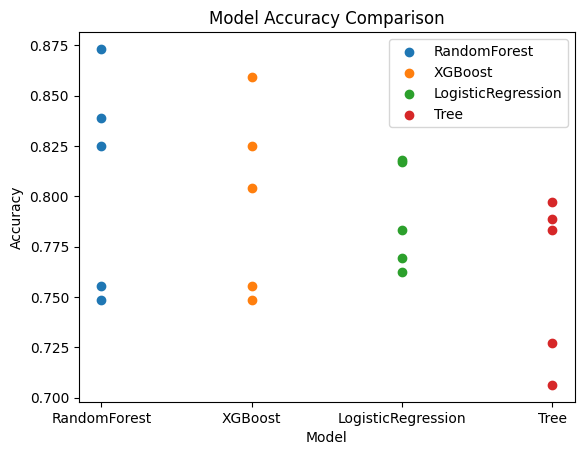

In [95]:
!pip install adjustText

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from matplotlib import pyplot as plt
# import decision tree
from sklearn import tree

X = df.drop('Label', axis=1)
y = df['Label']

# Define models
models = [
    ('RandomForest', RandomForestClassifier()),
    ('XGBoost', xgb.XGBClassifier()),
    ('LogisticRegression', LogisticRegression()),
    ('Tree', tree.DecisionTreeClassifier())
]

# Define metric
scoring = make_scorer(accuracy_score)

# Apply 5-fold cross-validation and store results
results = []
for name, model in models:
    cv_scores = cross_val_score(model, X, y, cv=5, scoring=scoring)
    results.append((name, cv_scores))
    print(f'{name} accuracies: {cv_scores}')

# Plot results
fig, ax = plt.subplots()

for i, (name, scores) in enumerate(results):
    ax.scatter([name]*len(scores), scores, label=name)

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.legend()

plt.show()

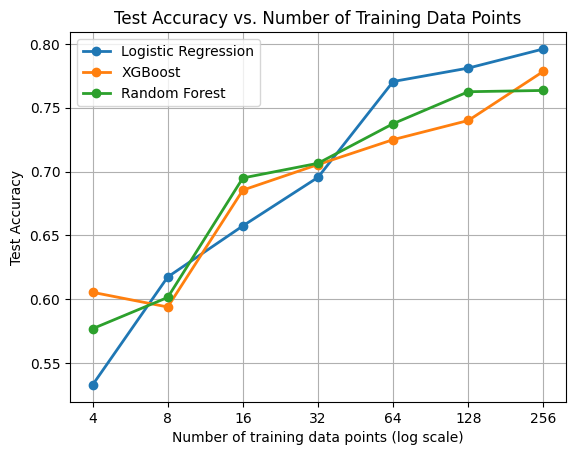

In [94]:
# Test logistic regression with different number of training data points: 4, 8, 16, 32, 64, 128, 256
import numpy as np

model = LogisticRegression()
test_size = 400
num_train_data = [4, 8, 16, 32, 64, 128, 256]
folds = 5
test_scores = []
def model_evaluation(model):
    test_size = 400
    num_train_data = [4, 8, 16, 32, 64, 128, 256]
    folds = 5
    test_scores = []
    for num in num_train_data:
        num_train_scores = []
        for _ in range(folds):
            X_train = X.sample(num)
            y_train = y[X_train.index]
            X_test = X.drop(X_train.index)[:test_size]
            y_test = y[X_test.index]
            try:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                num_train_scores.append(accuracy_score(y_test, y_pred))
            except:
                num_train_scores.append(np.nan)
        test_scores.append(sum(num_train_scores) / len(num_train_scores))

    return test_scores

# Initialize models
models = [LogisticRegression(), XGBClassifier(), RandomForestClassifier(), tree.DecisionTreeClassifier()]
model_names = ['Logistic Regression', 'XGBoost', 'Random Forest']
num_train_data = [4, 8, 16, 32, 64, 128, 256]

# dot plot of test scores vs. number of training data points
fig, ax = plt.subplots()

for model, model_name in zip(models, model_names):
    test_scores = model_evaluation(model)
    ax.plot(num_train_data, test_scores, marker='o', linewidth=2, label=model_name)

ax.set_xscale('log', base=2)  # set log scale
ax.set_xticks(num_train_data)  # set custom ticks
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # to keep the x-ticks as integers

ax.set_xlabel('Number of training data points (log scale)')
ax.set_ylabel('Test Accuracy')
ax.set_title('Test Accuracy vs. Number of Training Data Points')
ax.grid(True)
ax.legend()

plt.show()
